In [1]:
#from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *
from libs.convex_hull import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


/home/martin/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (None)/charset_normalizer (2.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
# Step 6: Extract match data from tracking data
data = compile_team_tracking_data("data", "England")
print(data.head())
one_match = extract_one_match(data, 1)
ripley_k_whole_match = ripley_k_by_indices(one_match, one_match.iloc[::48].index)


   Time [s]_team half_team  minute_team  Period_team   home_6_x  home_6_y  \
0       0.017598        1H            0            1  10.062882 -8.943584   
1       0.057598        1H            0            1  10.029277 -8.931254   
2       0.097598        1H            0            1   9.995811 -8.918193   
3       0.137598        1H            0            1   9.964137 -8.905257   
4       0.177598        1H            0            1   9.934836 -8.892676   

    home_1_x  home_1_y  home_10_x  home_10_y  ...  home_17_x  home_17_y  \
0  34.214111  0.585027   0.281299 -18.120819  ...        NaN        NaN   
1  34.198326  0.583323   0.278052 -18.117619  ...        NaN        NaN   
2  34.180202  0.580875   0.273438 -18.114445  ...        NaN        NaN   
3  34.160416  0.576764   0.267449 -18.111506  ...        NaN        NaN   
4  34.139824  0.569976   0.259829 -18.108561  ...        NaN        NaN   

   home_14_x  home_14_y  away_16_x  away_16_y  home_3_x  home_3_y  away_24_x  \
0     

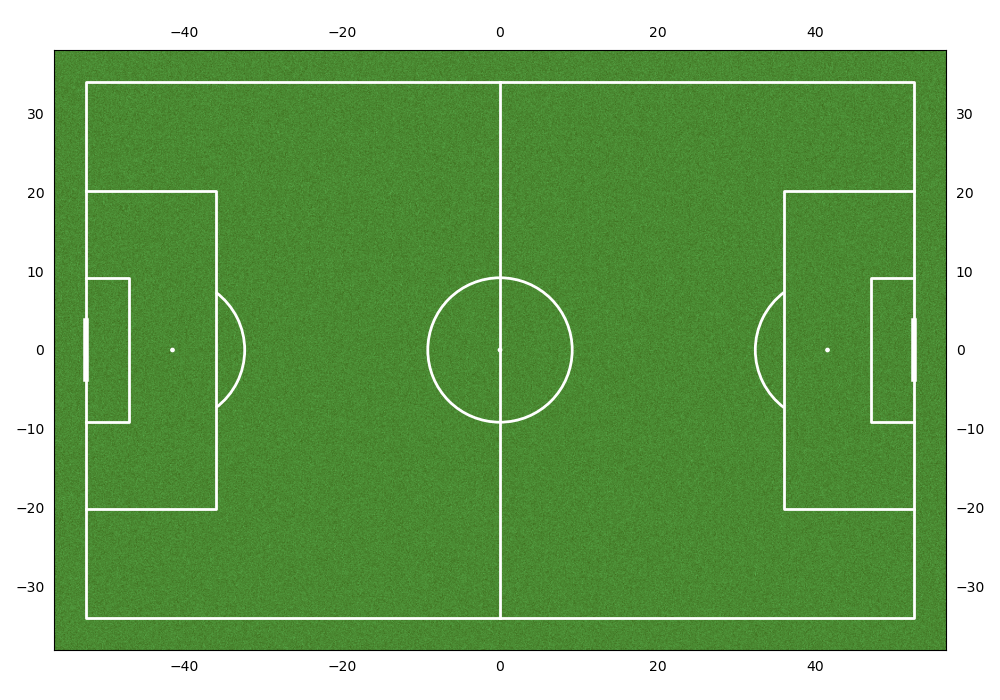

Cleared the current situation. All players are available for selection again.
Situation saved! Total saved situations: 1


In [7]:
%matplotlib widget

import matplotlib.pyplot as plt
from mplsoccer import Pitch 
import ipywidgets as widgets
import numpy as np
from IPython.display import display

# Initialize plot
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# List to store points for the current situation and vectors
players = []
points = []
vectors = []
situations = []

# Boolean to check if we're in vector drawing mode
draw_vector_mode = False
vector_start = None  # To store the start point of the vector

# Function to handle mouse clicks for points and vectors
def on_click(event):
    global vector_start, draw_vector_mode
    
    if event.inaxes:  # Check if click is inside plot
        x, y = event.xdata, event.ydata  # Get coordinates
        
        if draw_vector_mode:
            if vector_start is None:  # If no start point, set this as start point
                vector_start = (x, y)
                ax.plot(x, y, 'bo')  # Mark the start point with a blue dot
            else:
                # If there's already a start point, draw the vector from start to this point
                vector_end = (x, y)
                ax.annotate('', xy=vector_end, xytext=vector_start,
                            arrowprops=dict(facecolor='red', shrink=0.05))  # Draw vector
                vectors.append((vector_start, vector_end))  # Save the vector
                vector_start = None  # Reset the start point
        else:
            points.append((x, y))  # Add to list of points
            ax.plot(x, y, 'ro')  # Plot the point

# Function to save the current situation
def save_situation(_):
    if points or vectors:
        situations.append({'points': list(points), 'vectors': list(vectors)})  # Save the current points and vectors
        print(f"Situation saved! Total saved situations: {len(situations)}")
    else:
        print("No players or vectors to save!")

# Function to clear the current situation and reset player lists
def clear_situation(_):
    global points, vectors, vector_start, players, home_player_numbers, away_player_numbers
    
    points = []  # Clear the current points
    vectors = []  # Clear the current vectors
    players = []  # Clear the list of selected players
    vector_start = None  # Reset vector start point
    
    # Reset player lists and dropdown options using the backup lists
    home_player_numbers = backup_home_player_numbers.copy()
    away_player_numbers = backup_away_player_numbers.copy()
    
    home_players_dropdown.options = [("Select Player", "")] + [(f"{player}", player) for player in home_player_numbers]
    away_players_dropdown.options = [("Select Player", "")] + [(f"{player}", player) for player in away_player_numbers]
    
    ax.cla()  # Clear the plot
    football_pitch.draw(ax=ax)  # Redraw the empty pitch
    plt.draw()
    print("Cleared the current situation. All players are available for selection again.")

# Function to toggle vector drawing mode
def toggle_draw_vector(_):
    global draw_vector_mode
    draw_vector_mode = not draw_vector_mode  # Toggle the mode
    if draw_vector_mode:
        print("Vector drawing mode enabled. Select start and end points for the vector.")
    else:
        print("Switched to player drawing mode.")

def select_player(player_num, dropdown, player_list):
    players.append(player_num)
    print(players)
    
    # Remove the selected player from the dropdown options
    player_list.remove(player_num)
    updated_player_list = [(f"{player}", player) for player in player_list]
    dropdown.options = [("Select Player", "")] + updated_player_list

def remove_player(player_num, dropdown, player_list):
    try:
        players.remove(player_num)
        print(players)
        # Add the removed player back to the dropdown options
        player_list.append(player_num)
        player_list.sort()
        dropdown.options = [("Select Player", "")] + [(f"{player}", player) for player in player_list]
    except:
        print("Player not in list")

# Create save, clear, and toggle vector buttons
save_button = widgets.Button(description="Save Situation", button_style='success')
clear_button = widgets.Button(description="Clear", button_style='warning')
toggle_vector_button = widgets.Button(description="Toggle Draw Vector", button_style='info')

# Get unique home and away players using your regex logic
players_xy = one_match.filter(regex="^home").columns.to_numpy()  # Modify to match your dataframe
home_player_numbers = list(np.unique([player[:-1] for player in players_xy]))  # Convert to a list for mutation
backup_home_player_numbers = home_player_numbers.copy()  # Keep a backup of the original list

away_players_xy = one_match.filter(regex="^away").columns.to_numpy()  # Modify to match your dataframe
away_player_numbers = list(np.unique([player[:-1] for player in away_players_xy]))  # Convert to a list for mutation
backup_away_player_numbers = away_player_numbers.copy()  # Keep a backup of the original list

# Create dropdowns for home and away players
home_players_dropdown = widgets.Dropdown(
    options=[("Select Player", "")] + [(f"{player}", player) for player in home_player_numbers],  # Add "Select Player"
    description='Home Player:',
    disabled=False,
)

away_players_dropdown = widgets.Dropdown(
    options=[("Select Player", "")] + [(f"{player}", player) for player in away_player_numbers],  # Add "Select Player"
    description='Away Player:',
    disabled=False,
)

# Functions for adding/removing players from the dropdowns
def home_player_selected(change):
    selected_player = change['new']
    if selected_player:  # Only proceed if a valid player is selected
        select_player(selected_player, home_players_dropdown, home_player_numbers)

def away_player_selected(change):
    selected_player = change['new']
    if selected_player:  # Only proceed if a valid player is selected
        select_player(selected_player, away_players_dropdown, away_player_numbers)

# Observe changes in dropdown selection
home_players_dropdown.observe(home_player_selected, names='value')
away_players_dropdown.observe(away_player_selected, names='value')

# Connect button click events to their functions
save_button.on_click(save_situation)
clear_button.on_click(clear_situation)
toggle_vector_button.on_click(toggle_draw_vector)

# Create layout for the UI elements
ui_layout = widgets.HBox([widgets.VBox([home_players_dropdown, away_players_dropdown]), widgets.VBox([save_button, clear_button, toggle_vector_button])])

# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)

# Display the UI layout and plot
display(ui_layout)


In [4]:
regex = ""
for player in players:
    regex += "^"+player + "|" 
regex = regex[:-1]


#one_match = one_match.filter(regex = regex)
print(one_match.columns)

Index(['match_id', 'Time [s]', 'Time [s]_team', 'half_team', 'minute_team',
       'Period_team', 'home_6_x', 'home_6_y', 'home_1_x', 'home_1_y',
       'home_10_x', 'home_10_y', 'home_11_x', 'home_11_y', 'home_2_x',
       'home_2_y', 'home_7_x', 'home_7_y', 'home_8_x', 'home_8_y', 'home_9_x',
       'home_9_y', 'home_5_x', 'home_5_y', 'home_12_x', 'home_12_y',
       'home_4_x', 'home_4_y', 'home_20_x', 'home_20_y', 'home_16_x',
       'home_16_y', 'ball_x_team', 'ball_y_team', 'ball_z_team', 'half',
       'minute', 'Period', 'away_2_x', 'away_2_y', 'away_9_x', 'away_9_y',
       'away_1_x', 'away_1_y', 'away_14_x', 'away_14_y', 'away_20_x',
       'away_20_y', 'away_11_x', 'away_11_y', 'away_6_x', 'away_6_y',
       'away_10_x', 'away_10_y', 'away_17_x', 'away_17_y', 'ball_x', 'ball_y',
       'ball_z', 'home_19_x', 'home_19_y', 'home_21_x', 'home_21_y',
       'away_3_x', 'away_3_y', 'away_5_x', 'away_5_y', 'away_21_x',
       'away_21_y', 'away_23_x', 'away_23_y', 'away_19_x', 'a

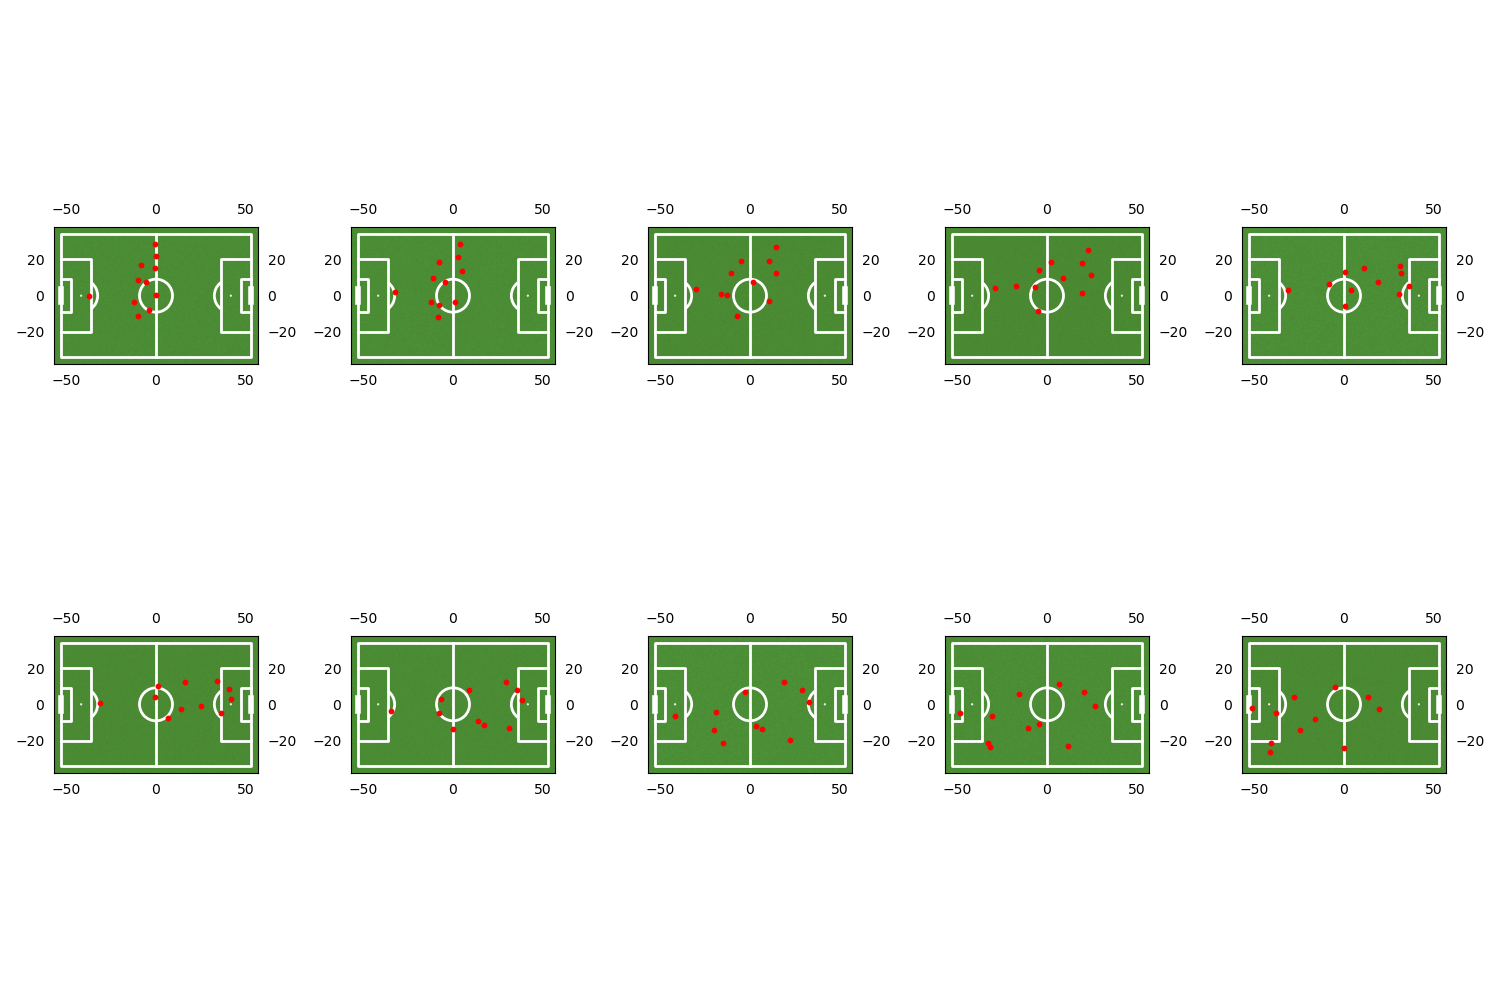

In [8]:

from libs.alpha_shape import *

alpha = 0.3

alpha_shapes, indices = alpha_shape(one_match.iloc[::48],alpha=alpha)

chosen_alpha_shape = alphashape.alphashape(points, alpha=alpha)
chosen_alpha_shape = normalize_geometry(chosen_alpha_shape)

top_100_alpha_shapes = top_n_similar_geometries(chosen_alpha_shape, alpha_shapes, indices, 100)


relevant_situations = np.array(top_100_alpha_shapes)[:,1]

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

data = one_match.filter(regex = "^home")

# Create the pitch with the desired settings
for hull, i in zip(top_100_alpha_shapes[:10], range(len(top_100_alpha_shapes[:10]))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    point_pairs = data.loc[hull[1]].to_numpy()

    points_current = np.array([np.array(list(pair)) for pair in zip(point_pairs[:-1:2], point_pairs[1::2])])


    # Scatter plot for convex hull points
    ax[row, col].scatter(points_current[:, 0], points_current[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()

10656
8112
10848
10704
78720
121152
8160
7968
27984
39168


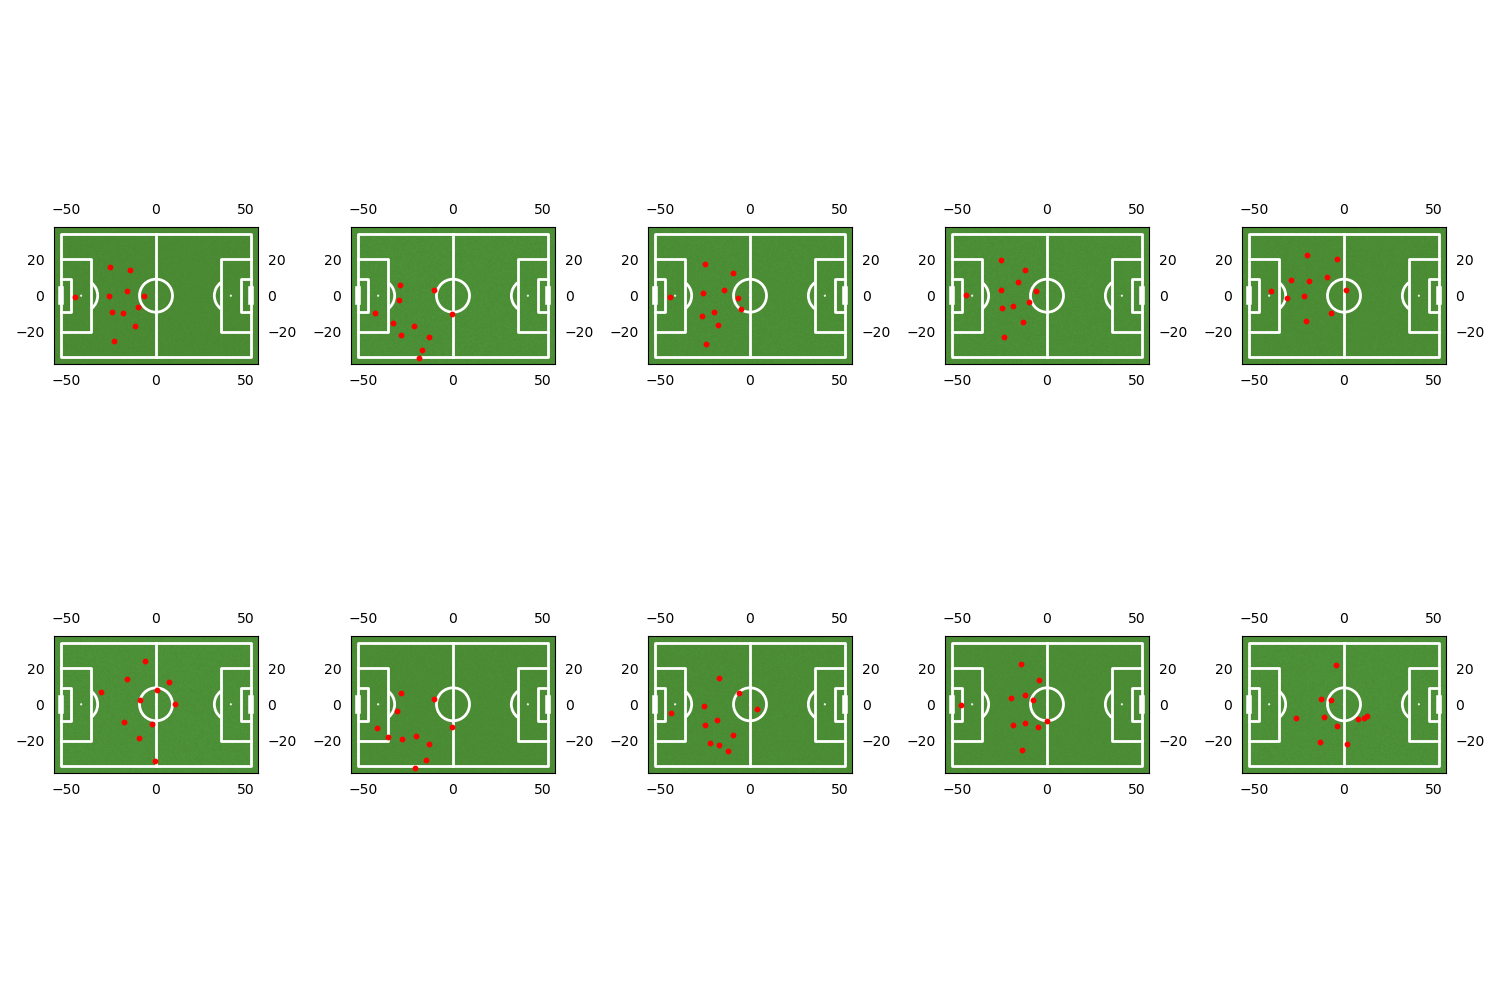

In [9]:
from libs.convex_hull import *

hulls, indices = convex_hull(one_match.iloc[::48])

chosen_hull = ConvexHull(points)
chosen_hull = normalize_hull(chosen_hull)

top_100_hulls = top_n_similar_hulls(chosen_hull, hulls,indices,100)

relevant_situations = np.array(top_100_hulls)[:,1]

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# Create the pitch with the desired settings
for hull, i in zip(top_100_hulls[:10], range(len(top_100_hulls[:10]))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    print(hull[1])
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    # Scatter plot for convex hull points
    ax[row, col].scatter(hull[0].points[:, 0], hull[0].points[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()
radii = np.arange(0, 34)

points_array = np.array(points)
points_series = pd.Series(points_array.flatten())


Collected 11 points.
0    -43.544549
1      0.590934
2    -29.227520
3     14.274466
4    -30.241115
5      1.984627
6    -29.354220
7    -13.345997
8    -17.064381
9     26.564304
10   -16.557583
11     9.079791
12   -18.077976
13    -6.630930
14   -17.571178
15   -27.156228
16    -9.842517
17    12.500674
18   -10.982811
19    -4.223642
20    -3.000751
21     1.224431
dtype: float64


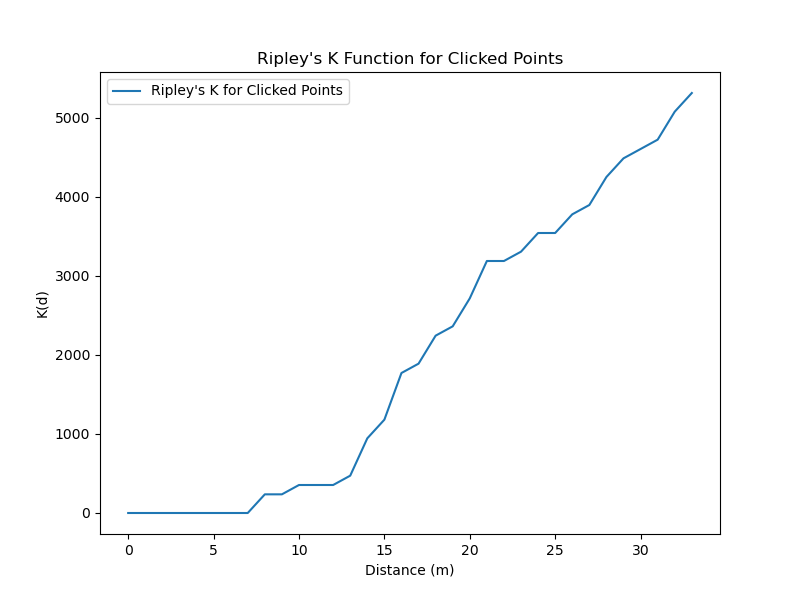

In [10]:
# Ensure the interactive pitch has captured points
if not points:
    print("Please click on the pitch to add points.")
else:
    print(f"Collected {len(points)} points.")

# Step 2: Convert the points from the interactive pitch into a usable format
points_array = np.array(points)  # Convert the collected points into a NumPy array

if points_array.shape[0] > 1:
    # Flatten the points for Ripley's K
    points_series = pd.Series(points_array.flatten())
    print(points_series)

    # Step 3: Define the radii for Ripley's K
    radii = np.arange(0, 34)  # Adjust the range based on your use case

    # Step 4: Calculate Ripley's K for the clicked points
    k_values_clicked = ripley_k(points_series, radii, width=105.0, height=68.0)

    # Step 5: Plot Ripley's K values for the clicked points
    plt.figure(figsize=(8, 6))
    plt.plot(radii, k_values_clicked, label="Ripley's K for Clicked Points")
    plt.xlabel('Distance (m)')
    plt.ylabel("K(d)")
    plt.title("Ripley's K Function for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

here
here


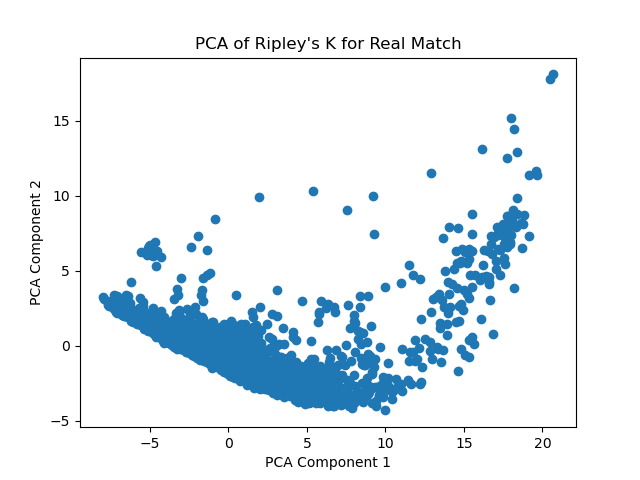

In [11]:
# Step 7: Calculate Ripley's K values for the real match data

ripley_k_vals_relevant = ripley_k_by_indices(one_match, relevant_situations)


#Added average position of team as feature

# Step 8: Perform PCA on the Ripley's K values from the real match data
pca_obj_ripley = PCAObject(ripley_k_whole_match, 10)  # Fit     PCA with 10 components
np_pca_ripley = pca_obj_ripley.transform(ripley_k_vals_relevant)
np_pca_ripley_full_match = pca_obj_ripley.transform(ripley_k_whole_match)

# Step 9: Plot the PCA-reduced Ripley's K values for the real match
plt.figure()
plt.scatter(np_pca_ripley_full_match[:, 0], np_pca_ripley_full_match[:, 1])
plt.title("PCA of Ripley's K for Real Match")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("pca_ripley.png")
plt.show()

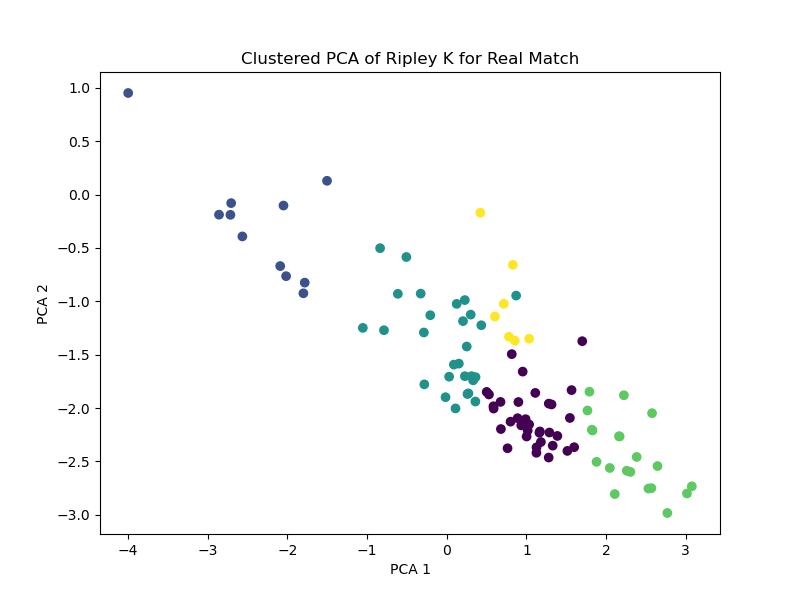

In [12]:
# Step 10: Cluster the PCA-reduced Ripley's K values using KMeans
clustering_obj_ripley = KMeansObject(np_pca_ripley, 5)  # Fit KMeans with 5 clusters
labels = clustering_obj_ripley.get_labels()

# Step 11: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clustered PCA of Ripley K for Real Match')
plt.savefig("pca_ripley_clustered.png")
plt.show()

here


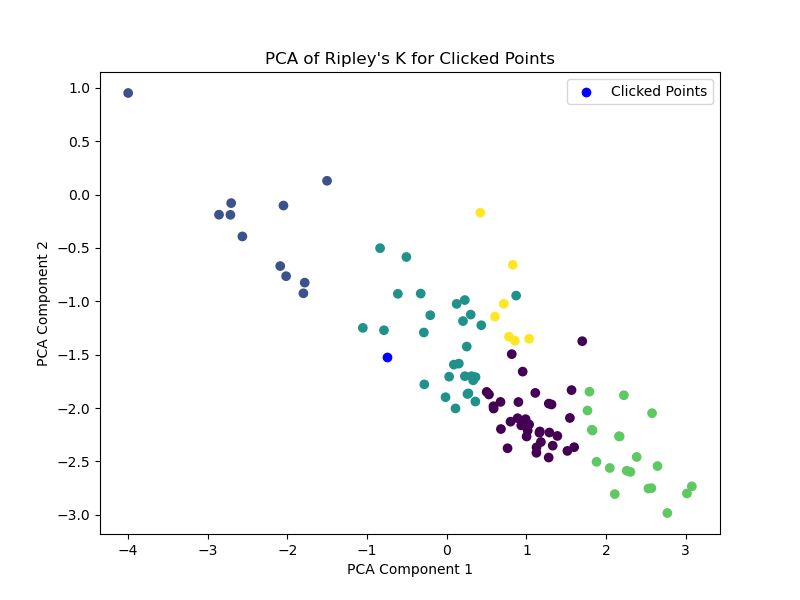

In [13]:
# Step 12: Apply PCA on the Ripley's K values for the clicked points
if points_array.shape[0] > 1:
    
    k_values_clicked_new = np.array(k_values_clicked).reshape(1, -1)  # Reshape for PCA compatibility
   



    
  
    reduced_k_values_clicked = pca_obj_ripley.transform(k_values_clicked_new)  # Transform using the same PCA model

    # Step 13: Plot the PCA-reduced clicked points

    plt.scatter(reduced_k_values_clicked[:, 0], reduced_k_values_clicked[:, 1], c='blue', label='Clicked Points')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title("PCA of Ripley's K for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [14]:
from sklearn.neighbors import KDTree

# Step 1: Build a KDTree from the PCA-reduced real match data
tree = KDTree(np_pca_ripley)

# Step 2: Query the 10 nearest neighbors for the clicked situation
distances, indices = tree.query(reduced_k_values_clicked, k=10)  # Find 10 nearest neighbors

# Flatten the indices
closest_indices = indices.flatten()
print("Closest situation indices:", closest_indices)


Closest situation indices: [22 30 68 64 43  6  1 95 34 91]


In [15]:
# Assuming `one_match` is a DataFrame where each row contains player positions for a specific situation
# Each row of `one_match` contains the player positions in the format: [(x1, y1), (x2, y2), ...]

# Retrieve the 10 closest situations from the real match

closest_situations_indices = np.array(top_100_alpha_shapes)[closest_indices,1]

print(closest_situations_indices)
closest_situations = one_match.loc[closest_situations_indices]


[1056 1440 3264 3072 2064 288 48 4560 1632 4368]


In [16]:
# Add time step columns to the closest situations. Each index is 24 time ticks
closest_situations

match_id  Time [s]  Time [s]_team half_team  minute_team  Period_team  \
1056         1     42.24          42.24        1H            0            1   
1440         1     57.60          57.60        1H            0            1   
3264         1    130.56         130.56        1H            2            1   
3072         1    122.88         122.88        1H            2            1   
2064         1     82.56          82.56        1H            1            1   
288          1     11.52          11.52        1H            0            1   
48           1      1.92           1.92        1H            0            1   
4560         1    182.40         182.40        1H            3            1   
1632         1     65.28          65.28        1H            1            1   
4368         1    174.72         174.72        1H            2            1   

       home_6_x   home_6_y   home_1_x  home_1_y  ...  away_21_x  away_21_y  \
1056 -32.485989  16.547979 -43.062954  0.517941  ... -10.585907   3.428772   
1440 -25.226048   9.818563 -44.912907 -0.701123  ...  -1.598500   7.257132   
3264   5.939424   7.610334 -19.927412 -7.158172  ...  27.864378  -8.957957   
3072   2.972636   0.176235 -22.349428 -6.171671  ...  23.497732  -3.154165   
2064 -12.504195  15.999314 -31.329184 -6.021972  ...   6.797209   0.336371   
288   -6.827328   2.873365 -34.142162 -3.779874  ...  27.144470   2.963455   
48   -10.955034   9.572880 -32.201439  2.089355  ...   9.623433  16.681208   
4560  -0.042754   5.777439 -26.398006  0.024269  ...  15.968863   3.068618   
1632 -27.895369   2.951410 -46.943798 -0.675530  ... -11.202733  -9.677670   
4368  -0.082811  18.732273 -26.669968  3.543086  ...  15.567033  21.142597   

      away_23_x  away_23_y  away_19_x  away_19_y  away_18_x  away_18_y  \
1056 -16.529861  -8.364697 -19.327110  12.470982        NaN        NaN   
1440  -2.162421  -5.059690 -11.575744  12.812366        NaN        NaN   
3264  25.402460 -19.902443  20.131413   6.317558        NaN        NaN   
3072  25.822546 -15.920135  17.006290   5.183090        NaN        NaN   
2064  11.121343 -13.645349   1.652639  11.513436        NaN        NaN   
288   26.529186  -7.030935  11.804944   8.075175        NaN        NaN   
48    12.718383   6.900303  -1.462090  12.056600        NaN        NaN   
4560  14.938343 -11.305057  11.662492   9.043381        NaN        NaN   
1632  -4.775773 -13.072415 -10.145242  -2.364954        NaN        NaN   
4368  18.640636   9.072974  12.802502  17.336002        NaN        NaN   

      away_15_x  away_15_y  
1056        NaN        NaN  
1440        NaN        NaN  
3264        NaN        NaN  
3072        NaN        NaN  
2064        NaN        NaN  
288         NaN        NaN  
48          NaN        NaN  
4560        NaN        NaN  
1632        NaN        NaN  
4368        NaN        NaN  

[10 rows x 77 columns]

      match_id  Time [s]  Time [s]_team half_team  minute_team  Period_team  \
1056         1     42.24          42.24        1H            0            1   
1440         1     57.60          57.60        1H            0            1   
3264         1    130.56         130.56        1H            2            1   
3072         1    122.88         122.88        1H            2            1   
2064         1     82.56          82.56        1H            1            1   
288          1     11.52          11.52        1H            0            1   
48           1      1.92           1.92        1H            0            1   
4560         1    182.40         182.40        1H            3            1   
1632         1     65.28          65.28        1H            1            1   
4368         1    174.72         174.72        1H            2            1   

       home_6_x   home_6_y   home_1_x  home_1_y  ...  away_21_x  away_21_y  \
1056 -32.485989  16.547979 -43.062954  0.517941  ...

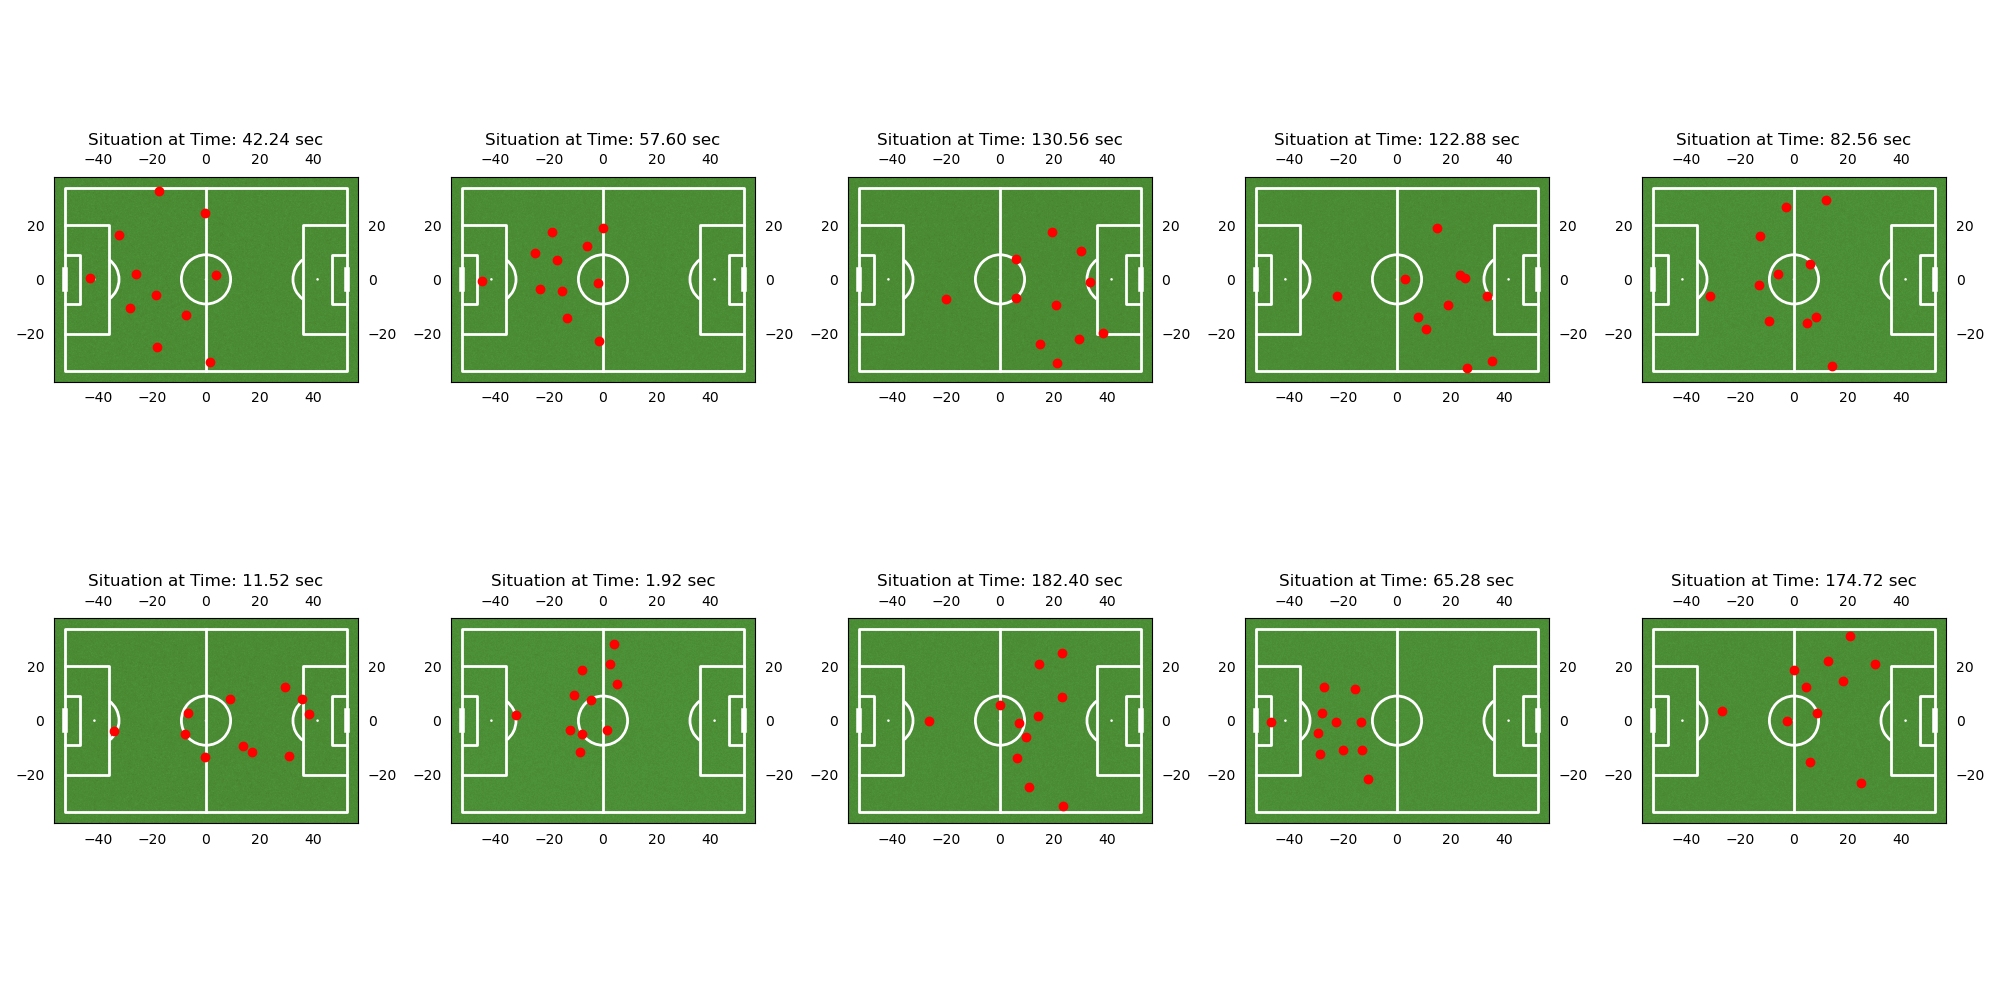

In [17]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import pandas as pd

# Function to extract player coordinates from the DataFrame
def extract_player_positions(row):
    # Extract home player positions (x and y)
    home_x_cols = [col for col in row.index if 'home' in col and '_x' in col]
    home_y_cols = [col for col in row.index if 'home' in col and '_y' in col]
    
    home_positions = [(row[x], row[y]) for x, y in zip(home_x_cols, home_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    # Extract away player positions (x and y)
    away_x_cols = [col for col in row.index if 'away' in col and '_x' in col]
    away_y_cols = [col for col in row.index if 'away' in col and '_y' in col]
    
    away_positions = [(row[x], row[y]) for x, y in zip(away_x_cols, away_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    return home_positions, away_positions

# Function to plot a single situation on the pitch
def plot_situation(row, ax):
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax)
    
    # Extract player positions from the row
    home_positions, away_positions = extract_player_positions(row)
    
    # Plot home team players (red)
    for pos in home_positions:
        ax.plot(pos[0], pos[1], 'ro', label='Home Team')  # Mark home players as red dots

    # Plot away team players (blue)
    #for pos in away_positions:
    #    ax.plot(pos[0], pos[1], 'bo', label='Away Team')  # Mark away players as blue dots
    
    ax.set_title(f"Situation at Time: {row['Time [s]']:.2f} sec")

# Step 4: Visualize the 10 closest situations on the pitch
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create a grid for 10 situations
axes = axes.flatten()
print(closest_situations)

# Make sure closest_situations contains all required columns from the original DataFrame
if 'Time [s]' in closest_situations.columns:
    for idx, situation_index in enumerate(closest_situations.index):  # Use the index of the closest situations
        plot_situation(closest_situations.loc[situation_index], axes[idx])  # Pass the row to plot_situation
else:
    print("Ensure that closest_situations contains full rows, including player position columns.")

plt.tight_layout()
plt.show()


In [18]:
import vlc
import time
import tkinter as tk
from tkinter import Button, Label
import numpy as np

# Path to your video file
video_path = "/data/video/EURO2020Russia_vs_Denmark_1st_Half_769630.mp4"

# Video offset in seconds (adjust this value to align video and match time)
video_offset = 52  # Example: If the video starts 2 minutes before the actual match starts

# Create a VLC instance
vlc_instance = vlc.Instance()

# Create a VLC media player
player = vlc_instance.media_player_new()

# Load the media file
media = vlc_instance.media_new(video_path)
player.set_media(media)

# Pause the video initially
player.play()
time.sleep(2)  # Wait for the video to load
player.pause()

# Function to seek to a specific time in seconds
def seek_to_time(player, seconds):
    if isinstance(seconds, (int, float)):  # Ensure that the time is a scalar number
        player.set_time(int((seconds + video_offset) * 1000))  # Add video_offset to align with match time

# Pause the video
def pause_video():
    player.pause()

# Resume the video
def play_video():
    player.play()

# Close the video properly and destroy the tkinter window
def close_video():
    if player.is_playing():
        player.stop()
    player.release()
    root.destroy()  # Close the tkinter window gracefully

# Function to update the current time in the video player
def update_time_label():
    current_time = player.get_time() // 1000  # Get current time in milliseconds, convert to seconds
    time_label.config(text=f"Time: {current_time} seconds")
    root.after(1000, update_time_label)  # Update every second

# Function to skip to the next closest situation time
def next_time():
    global current_index
    if len(closest_situations) > 0:
        current_index = (current_index + 1) % len(closest_situations)
        specific_time_in_seconds = closest_situations.iloc[current_index]['Time [s]']  # Extract the correct time from closest situations
        seek_to_time(player, specific_time_in_seconds)
        time_label.config(text=f"Time: {specific_time_in_seconds} seconds")

# Function to skip to the previous closest situation time
def previous_time():
    global current_index
    if len(closest_situations) > 0:
        current_index = (current_index - 1) % len(closest_situations)
        specific_time_in_seconds = closest_situations.iloc[current_index]['Time [s]']  # Extract the correct time from closest situations
        seek_to_time(player, specific_time_in_seconds)
        time_label.config(text=f"Time: {specific_time_in_seconds} seconds")

# Create the Tkinter window
root = tk.Tk()
root.title("VLC Video Control")

# Pause Button
pause_button = Button(root, text="Pause", command=pause_video)
pause_button.pack(side=tk.LEFT)

# Play Button
play_button = Button(root, text="Play", command=play_video)
play_button.pack(side=tk.LEFT)

# Next Button
next_button = Button(root, text="Next", command=next_time)
next_button.pack(side=tk.LEFT)

# Previous Button
previous_button = Button(root, text="Previous", command=previous_time)
previous_button.pack(side=tk.LEFT)

# Close Button
close_button = Button(root, text="Close", command=close_video)
close_button.pack(side=tk.LEFT)

# Time Label
time_label = Label(root, text="Time: 0 seconds")
time_label.pack(side=tk.LEFT)

# Initialize index for closest situations
current_index = 0

# Ensure closest_situations contains valid data and a 'Time [s]' column
if 'closest_situations' in globals() and not closest_situations.empty:
    specific_time_in_seconds = closest_situations.iloc[current_index]['Time [s]']  # Access the first situation's time
    print(f"Initial Time: {specific_time_in_seconds} seconds")
    seek_to_time(player, specific_time_in_seconds)
else:
    print("Error: closest_situations is not properly initialized or is empty.")

# Start updating the time label
update_time_label()

# Keep the video running
root.mainloop()


[00007f03d00016d0] filesystem stream error: cannot open file /data/video/EURO2020Russia_vs_Denmark_1st_Half_769630.mp4 (No such file or directory)
[0000559f0f7396c0] main input error: Your input can't be opened
[0000559f0f7396c0] main input error: VLC is unable to open the MRL 'file:///data/video/EURO2020Russia_vs_Denmark_1st_Half_769630.mp4'. Check the log for details.


Initial Time: 42.24 seconds
